<a href="https://colab.research.google.com/github/moritzjuergens/aki/blob/main/AKI_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anwendungen Künstlicher Intelligenz**
### Projektthema: Towards Neural Network-based Reasoning

*Nach dem Modell von Peng et Al.*
#### s0556759 Gökalp Yildiz
#### s0581194 Moritz Jürgens
#### s0566397 Aurielle Tagou

[Colab Notebook](https://colab.research.google.com/drive/1XyXp-tjgQ-2hvvZ-RouAvFdyqsR5Rhmw?usp=sharing)

---


Das Ziel dieses Projektes ist es, das Modell aus der Arbeit "Towards Neural Network-based Reasoning" von Peng et Al. möglichst genau nachzubauen. 

Während der Bearbeitung des Projekts ist unser Team auf viele verschiedene Probleme und Herausforderungen gestoßen, von denen viele überwunden werden konnten, manche jedoch nicht. 
So mussten wir bei der Implementierung des Modells aus verschiedenen Gründen Kompromisse eingehen.
Angefangen mit dem Datensatz: Die Arbeit "Towards Neural Network-based Reasoning" verlangt nach einem Datensatz, der im Format [Frage, Fakt_1, ..., Fakt_k] aufgebaut ist. Einen ähnlichen Datensatz hatten wir ursprünglich ausprobiert, jedoch ohne die relevante Erfahrung, wie das Preprocessing funktionieren sollte. Da wir nach einigen Wochen nur wenige Fortschritte in dem Preprocessing dieses Datensatzes verzeichnen konnten, haben wir uns dazu entschieden das "Stanford Question and Answering Dataset" (SQuAD) zu benutzen. Der wesentliche Unterschied hierbei ist es, dass eine Frage einen zugehörigen Kontextartikel und *keine* Reihe an Fakten besitzt. 

Demnach mussten auch Kompromisse in der eigentlichen Architektur vorgenommen werden. So musste die Fragen-Fakt Interaktion überdacht und verändert werden. Zudem wurde der Teil des Natural Language Processing größer als zu Beginn gedacht. 

Nichtsdestotrotz war die Bearbeitung des Projekts eine sehr interessante und bereichernde Möglichkeit, sich näher mit den Konzepten der künstlichen Intelligenz auseinander zu setzen. 
Diese Erfahrung läd dazu ein, weitere Veränderungen bzw. Erweiterungen des bestehenden Modells zu bearbeiten. 
Zukünftige Projekte könnten beispielsweise die Umsetzung mit dem orginalen bAbI-Datensatz auf sich nehmen. Des Weiteren wäre eine Implementierung der Architektur treuer des Quellenmaterials ein wünschenswertes Projekt.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import json, re, unicodedata, string, typing, time
import torch.nn.functional as F
import spacy
from collections import Counter
import pickle
from nltk import word_tokenize
nlp = spacy.load('en')

##Preprocessing

Ein großer Teil des Preprocessing und des Word Embeddings konnte nur Dank des  [Repositories](https://github.com/kushalj001/pytorch-question-answering) von Kushalj001 ermöglicht werden. Im Generellen war die Arbeit von GitHub-User Kushal eine große Hilfe bei der Strukturierung und der technischen Umsetzung des Projekts.

---

### Laden und Einpflegen des Datensatzes

Zunächst wird der Datensatz im JSON Format geladen. Dabei werden direkt zwei Datensätze geladen: Der Train- und der Validation-Datensatz.
Der Train-Datensatz wird am Ende des Notebooks genutzt, um das Modell zu trainieren. Der Validation-Datensatz wird genutzt, um das trainierte Modell auf Over- bzw. Under-Fitting zu prüfen.

[[Dataset](https://paperswithcode.com/dataset/squad)]

Nachdem die Splits des Datensatzes geladen wurden, wird die Funktion ```parse_data``` aufgerufen.
Die Funktion durchläuft den Datensatz und erstellt Listen-Objekte für die Schlüssel-Werte-Paare. 
Abschließend werden die generierten Listen in Pandas DataFrames umgewandelt.

In [ ]:
def parse_data(data:dict)->list:

    data = data['data']
    qa_list = []

    for paragraphs in data:

        for paragraph in paragraphs['paragraphs']:
            context = paragraph['context']

            for qa in paragraph['qas']:
                
                id = qa['id']
                question = qa['question']
                
                for ans in qa['answers']:
                    answer = ans['text']
                    ans_start = ans['answer_start']
                    ans_end = ans_start + len(answer)
                    
                    qa_dict = {}
                    qa_dict['id'] = id
                    qa_dict['context'] = context
                    qa_dict['question'] = question
                    qa_dict['label'] = [ans_start, ans_end]

                    qa_dict['answer'] = answer
                    qa_list.append(qa_dict)    

    
    return qa_list

In [ ]:
ds_train = open('/content/drive/MyDrive/Colab Notebooks/Data/squad_train.json')
ds_valid = open('/content/drive/MyDrive/Colab Notebooks/Data/squad_dev.json')

ds_train = json.load(ds_train)
ds_valid = json.load(ds_valid)

train_list = parse_data(ds_train)
valid_list = parse_data(ds_valid)

ds_train = pd.DataFrame(train_list)
ds_valid = pd.DataFrame(valid_list)

### Erstellung des Vocabularies
Im nächsten Schritt wird das Vocabulary erstellt. Vocabularies im Natural Language Processing sind die Ansammlungen aller einzigartiger Wörter, welche im Datensatz verwendet werden. Sie bilden die Grundlage für die Tokenization und später das Word Embedding, welches es ermöglicht ein Modell für die Analyse von Text zu trainieren.

Zunächst werden mit Hilfe der Funktion ```get_vocab_text``` die Texte der Spalten "Questions" und "Context" in einem Listen-Objekt gesammelt. 
Diese werden dann weiter in der Funktion ```build_word_vocab``` verwendet. 
Diese Funktion dient dazu die Strings der Questions und Context Spalten in Integer umzuwandeln, welche im Laufe des Projekts in das Reasoning Modell eingepflegt werden. 
Die Funktionen nutzen das Pre-Trained Modell ```en_core_web_sm``` von spaCy.io als Tokenizer. 

Die Funktion ```build_word_vocab``` gibt drei Werte zurück: 
* Ein Python Dictionary-Objekt, welches das Mapping von Wort zu Index enthält
* Ein zweites Dictionary-Object, welches in umgekehrter Reihenfolge das Mapping von Index zu Wort enthählt
* Ein Listen-Objekt, welches die Frequenz der einzigartigen Wörter des Datensatzes enthält  


In [ ]:
def get_vocab_text(frames:list):
  
    text = []
    total = 0
    for frame in frames:
        unique_contexts = list(frame.context.unique())
        unique_questions = list(frame.question.unique())
        total += frame.context.nunique() + frame.question.nunique()
        text.extend(unique_contexts + unique_questions)
    
    assert len(text) == total
    
    return text

vocab_text = gather_text_for_vocab([ds_train, ds_valid])
print("Number of sentences in dataset: ", len(vocab_text))

Number of sentences in dataset:  118852


In [ ]:
# build word vocabulary

def build_word_vocab(vocab_text):
    
    words = []
    for sent in vocab_text:
        for word in nlp(sent, disable=['parser','tagger','ner']):
            words.append(word.text)

    word_counter = Counter(words)
    word_vocab = sorted(word_counter, key=word_counter.get, reverse=True)
    word_vocab.insert(0, '<unk>')
    word_vocab.insert(1, '<pad>')
    word2idx = {word:idx for idx, word in enumerate(word_vocab)}
    idx2word = {v:k for k,v in word2idx.items()}
    
    return word2idx, idx2word, word_vocab

word2idx, idx2word, word_vocab = build_word_vocab(vocab_text)

###Tokenization

Die Funktionen ```context_to_ids``` und ```question_to_ids``` nutzen nun die im vorherigen Schritt generierten Dictionaries ```word2idx```, welches das Mapping von Wort auf Index beinhaltet.
So wird der Text des Datensatzes nun in Tokens umgewandelt. 
Das heißt, dass die einzigartigen Wörter jeweils in eine einzigartige Nummer umgewandelt werden, um so dem Modell den Text zu abstrahieren.
Die Question- und Context-IDs sind letztendlich die Werte, die embedded und dann dem Modell zur Rechnung übergeben werden.

In [ ]:
def context_to_ids(text, word2idx):
    context_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    context_ids = [word2idx[word] for word in context_tokens]
    assert len(context_ids) == len(context_tokens)
    return context_ids

def question_to_ids(text, word2idx):  
    question_tokens = [w.text for w in nlp(text, disable=['parser','tagger','ner'])]
    question_ids = [word2idx[word] for word in question_tokens]
    assert len(question_ids) == len(question_tokens)
    return question_ids

ds_train['context_ids'] = ds_train.context.apply(context_to_ids, word2idx=word2idx)
ds_valid['context_ids'] = ds_valid.context.apply(context_to_ids, word2idx=word2idx)
ds_train['question_ids'] = ds_train.question.apply(question_to_ids,  word2idx=word2idx)
ds_valid['question_ids'] = ds_valid.question.apply(question_to_ids,  word2idx=word2idx)

###Fehler-Reinigung

Im nächsten Schritt werden die generierten Indizes auf mögliche Fehler überprüft und bereinigt. Hier erfolgt auch die Erstellung einer ```label```-Spalte im Datensatz. Diese beinhaltet die Start- und End-Indizes der Antworten im Bezug auf den Kontext. 

Zum Abschluss des Preprocessings werden noch die Antworten in der Spalte  ```label``` in Tokens umgewandelt, später beim Trainieren des Modells die Antworten einpflegen zu können.

In [ ]:
def test_indices(df, idx2word):

    start_value_error = []
    end_value_error = []
    assert_error = []
    for index, row in df.iterrows():

        answer_tokens = [w.text for w in nlp(row['answer'], disable=['parser','tagger','ner'])]
    
        start_token = answer_tokens[0]
        end_token = answer_tokens[-1]
        
        context_span  = [(word.idx, word.idx + len(word.text)) 
                         for word in nlp(row['context'], disable=['parser','tagger','ner'])]

        starts, ends = zip(*context_span)

        answer_start, answer_end = row['label']

        try:
            start_idx = starts.index(answer_start)
        except:
            start_value_error.append(index)
        try:
            end_idx  = ends.index(answer_end)
        except:
            end_value_error.append(index)

        try:
            assert idx2word[row['context_ids'][start_idx]] == answer_tokens[0]
            assert idx2word[row['context_ids'][end_idx]] == answer_tokens[-1]
        except:
            assert_error.append(index)


    return start_value_error, end_value_error, assert_error

In [ ]:
def get_error_indices(df, idx2word):
    start_value_error, end_value_error, assert_error = test_indices(df, idx2word)
    err_idx = start_value_error + end_value_error + assert_error
    err_idx = set(err_idx)
    print(f"Error indices: {len(err_idx)}")
    
    return err_idx

train_err = get_error_indices(ds_train, idx2word)
valid_err = get_error_indices(ds_valid, idx2word)

ds_train.drop(train_err, inplace=True)
ds_valid.drop(valid_err, inplace=True)

Exception reporting mode: Context
Error indices: 1002
Exception reporting mode: Context
Error indices: 431


In [ ]:
def index_answer(row, idx2word):
    
    context_span = [(word.idx, word.idx + len(word.text)) for word in nlp(row.context, disable=['parser','tagger','ner'])]
    starts, ends = zip(*context_span)
    
    answer_start, answer_end = row.label
    start_idx = starts.index(answer_start)
 
    end_idx  = ends.index(answer_end)
    
    ans_toks = [w.text for w in nlp(row.answer,disable=['parser','tagger','ner'])]
    ans_start = ans_toks[0]
    ans_end = ans_toks[-1]
    assert idx2word[row.context_ids[start_idx]] == ans_start
    assert idx2word[row.context_ids[end_idx]] == ans_end
    
    return [start_idx, end_idx]

train_label_idx = ds_train.apply(index_answer, axis=1, idx2word=idx2word)
valid_label_idx = ds_valid.apply(index_answer, axis=1, idx2word=idx2word)

ds_train['label_idx'] = train_label_idx
ds_valid['label_idx'] = valid_label_idx

##Dataset Loader

Die Klasse ```SquadDataset``` fungiert als Data Loader des Modells. Hier wird der Datensatz in Batches unterteilt, um die Leistung des Modells beim Trainieren zu verbessern.

In [ ]:
class SquadDataset:

    def __init__(self, data, batch_size):
        
        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data
    
    def get_span(self, text):
        
        text = nlp(text, disable=['parser','tagger','ner'])
        span = [(w.idx, w.idx+len(w.text)) for w in text]

        return span

    def __len__(self):
        return len(self.data)
    
    def __iter__(self):

        for batch in self.data:
                            
            spans = []
            context_text = []
            answer_text = []
            
            max_context_len = max([len(ctx) for ctx in batch.context_ids])
            padded_context = torch.LongTensor(len(batch), max_context_len).fill_(1)
            
            for ctx in batch.context:
                context_text.append(ctx)
                spans.append(self.get_span(ctx))
            
            for ans in batch.answer:
                answer_text.append(ans)
                
            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)
            
            max_question_len = max([len(ques) for ques in batch.question_ids])
            padded_question = torch.LongTensor(len(batch), max_question_len).fill_(1)
            
            for i, ques in enumerate(batch.question_ids):
                padded_question[i,: len(ques)] = torch.LongTensor(ques)
                
            
            label = torch.LongTensor(list(batch.label_idx))
            context_mask = torch.eq(padded_context, 1)
            question_mask = torch.eq(padded_question, 1)
            
            ids = list(batch.id)  
            
            yield (padded_context, padded_question, context_mask, 
                   question_mask, label, context_text, answer_text, ids)

In [ ]:
train_dataset = SquadDataset(ds_train, 32)
valid_dataset = SquadDataset(ds_valid, 32)
a = next(iter(train_dataset))

##Word Embedding

Das Word Embedding ist ein essenzieller Teil der Architektur. Hier wird den Tokens, die in den vorherigen Schritten generiert wurden, dem Neuralen Netzwerk gegenüber eine Bedeutung gegeben. 
Zum Embedden des Datensatzes wurde das Pre-Trained Modell [GloVe](https://nlp.stanford.edu/projects/glove/) genutzt. 
GloVe steht für: "Global Vectors for Word Representation" und ist ein Algorithmus, welcher versucht Wörtern eine semantisch sinnvolle Konnotation zu geben. 

So wird aus dem Beispielsatz:
>"king is to queen as man is to woman" 

die folgende Konnotation abgeleitet 
>"king − queen = man − woman".

[Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation]

Wörter, die zwar im Vocabulary vorkommen aber nicht im GloVe-Modell enthalten sind, werden mit einem Null-Vektor initialisiert. 

Abschließend wird die Gewichts-Matrix des Embeddings gespeichert. Diese wird im Reasoning-Modell genutzt, um die Fragen und Antworten der jeweiligen Batches zu embedden.

In [ ]:
def create_glove_matrix():
    
    glove_dict = {}
    with open("/content/drive/MyDrive/Colab Notebooks/Data/glove.840B.300d.txt", "r", encoding="utf-8") as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_dict[word] = vector

    f.close()
    
    return glove_dict

In [ ]:
glove_dict = create_glove_matrix()

In [ ]:
def create_word_embedding(glove_dict):
    weights_matrix = np.zeros((len(word_vocab), 300))
    words_found = 0
    for i, word in enumerate(word_vocab):
        try:
            weights_matrix[i] = glove_dict[word]
            words_found += 1
        except:
            pass
    return weights_matrix, words_found

In [ ]:
weights_matrix, words_found = create_word_embedding(glove_dict)

In [ ]:
print("Total words found in glove vocab: ", words_found)

Total words found in glove vocab:  91634


In [ ]:
np.save('drqaglove_vt.npy',weights_matrix)

## Recurrent Neural Network
Nun wird die Encoding-Layer der Architektur implementiert. Zum Encoden der Fragen und Antworten wird ein Recurrent Neural Network genutzt. Dieses bekommt die Parameter ```input_dim```, ```hidden_dim``` und ```num_layers``` übergeben. 

Der Parameter ```num_layers``` wird genutzt, um dynamisch anhand von zentral definierten Variablen Layers dem RNN hinzuzufügen.  

Sowohl ```input_dim``` als auch ```hidden_dim``` werden dann dem RNN übergeben, um die tatsächliche Matrix-Rechnung in der Forward-Funktion der Klasse ```CustomRNN``` durchzuführen.
Die CustomRNN-Layer besteht aus einer Sigmoid Funktion, welche als Output eine Matrix ausgibt, die im weiteren Verlauf der Architektur als Grundlage dienen wird.

##### Class Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#import custom_rnn as rnn

class RNN(nn.Module):

    def __init__(self,input_dim, hidden_dim, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        for i in range(self.num_layers):
            input_dim = input_dim if i == 0 else hidden_dim * 2
            self.layers.append(CustomRNN(input_dim, hidden_dim))
        self.layer_out = nn.Linear(10, 1) # input_size, output_size

    def forward(self, x):

        outputs = [x]
        for i in range(self.num_layers):
            rnn_input = outputs[-1]
            rnn_out, (hidden, cell) = self.layers[i](rnn_input)
            outputs.append(rnn_out)
        output = torch.relu(self.layer_out(outputs))
        
        #out, hidden = self.layer_1(x) # returns tuple consisting of output and sequence
        #out, hidden = self.layer_2(hidden)
        output = torch.relu(self.layer_out(output))
        return output


##### Forward-function

In [ ]:
import torch
import torch.nn as nn
import math


class CustomRNN(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        bs, seq_sz, _ = x.shape  # assumes x.shape represents (batch_size, sequence_size, input_size)
        hidden_seq = []
        h_t = torch.zeros(bs, self.hidden_size)  # initialize states

        for t in range(seq_sz):
            x_t = x[:, t, :]
            h_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)

            hidden_seq.append(h_t.unsqueeze(0))  # transform h_t from shape (batch_size, input_size) to shape (1, batch_size, input_size)

        # reshape hidden_seq
        hidden_seq = torch.cat(hidden_seq,dim=0)  # concatenate list of tensors into one tensor along dimension 0 (sequence_size, batch_size, input_size)
        hidden_seq = hidden_seq.transpose(0,1).contiguous()  # exchange new dimension with batch dimension so that new tensor has required shape (batch_size, sequence_size, input_size)
        return h_t, hidden_seq

## Long Short Term Memory

Anschließend wird das LSTM-Modell implementiert. Dieses Modell stellt die "Reasoning-Layer" der Architektur dar. Hier werden die Fragen und der Kontext miteinander interagieren, um so schließlich eine Antwort generieren zu können.

LSTMs sind eine der meistgenutzten Netzwerk-Modelle, da sie den regulären RNNs einige wichtige Vorteile bieten. LSTMs wurden speziell dafür entwickelt, das sogenannte "Long-Term Dependency Problem" zu überwinden. Bei dem Long-Term Dependency Problem handelt es sich um die Eigenschaft standardmäßiger RNN Algorithmen Informationen, die in der Sequenz länger zurückliegen, weniger stark zu berücksichtigen. Dies kann dazu führen dass ein RNN ein praktisch kurzsichtiges Ergebnis erzeugt. 
LSTMs hingegen können auf Grund ihres Aufbaus längerfristig Informationen "im Gedächtnis" behalten. 

Das besondere Merkmal eines LSTMs ist der "Cell State", welcher in Form der oberen horizontalen Linie (auch C_t-1) Informationen größtenteils unverändert aus den vorherigen Sequenzen überträgt. Über sogenannte "Gates" können nun aktuelle Informationen gezielt in den Cell State übertragen werden. Die Gates werden im Diagramm mit Hilfe vertikaler Pfeile dargestellt. 

So ist das erste Gate - auch "Forget Gate" genannt - ein zusammenschluss einer Sigmoid Funktion und einer Multiplikation. Das Forget Gate entscheided, welche Informationen aus dem Cell State "vergessen" werden sollen. Das folgende Gate soll nun entscheiden, welche neuen Informationen in den Cell State aufgenommen werden sollen. Dies erfolgt über eine Multiplikation der Ergebnisse einer Sigmoid- und einer tanh-Funktion. Das Ergebnis der Multiplikation wird anschließend mit dem Ergebnis des Forget Gates addiert, um so auf den Cell State Wert C_t zu kommen.
Abschließend wird noch der Output der LSTM-Layer berechnet. 


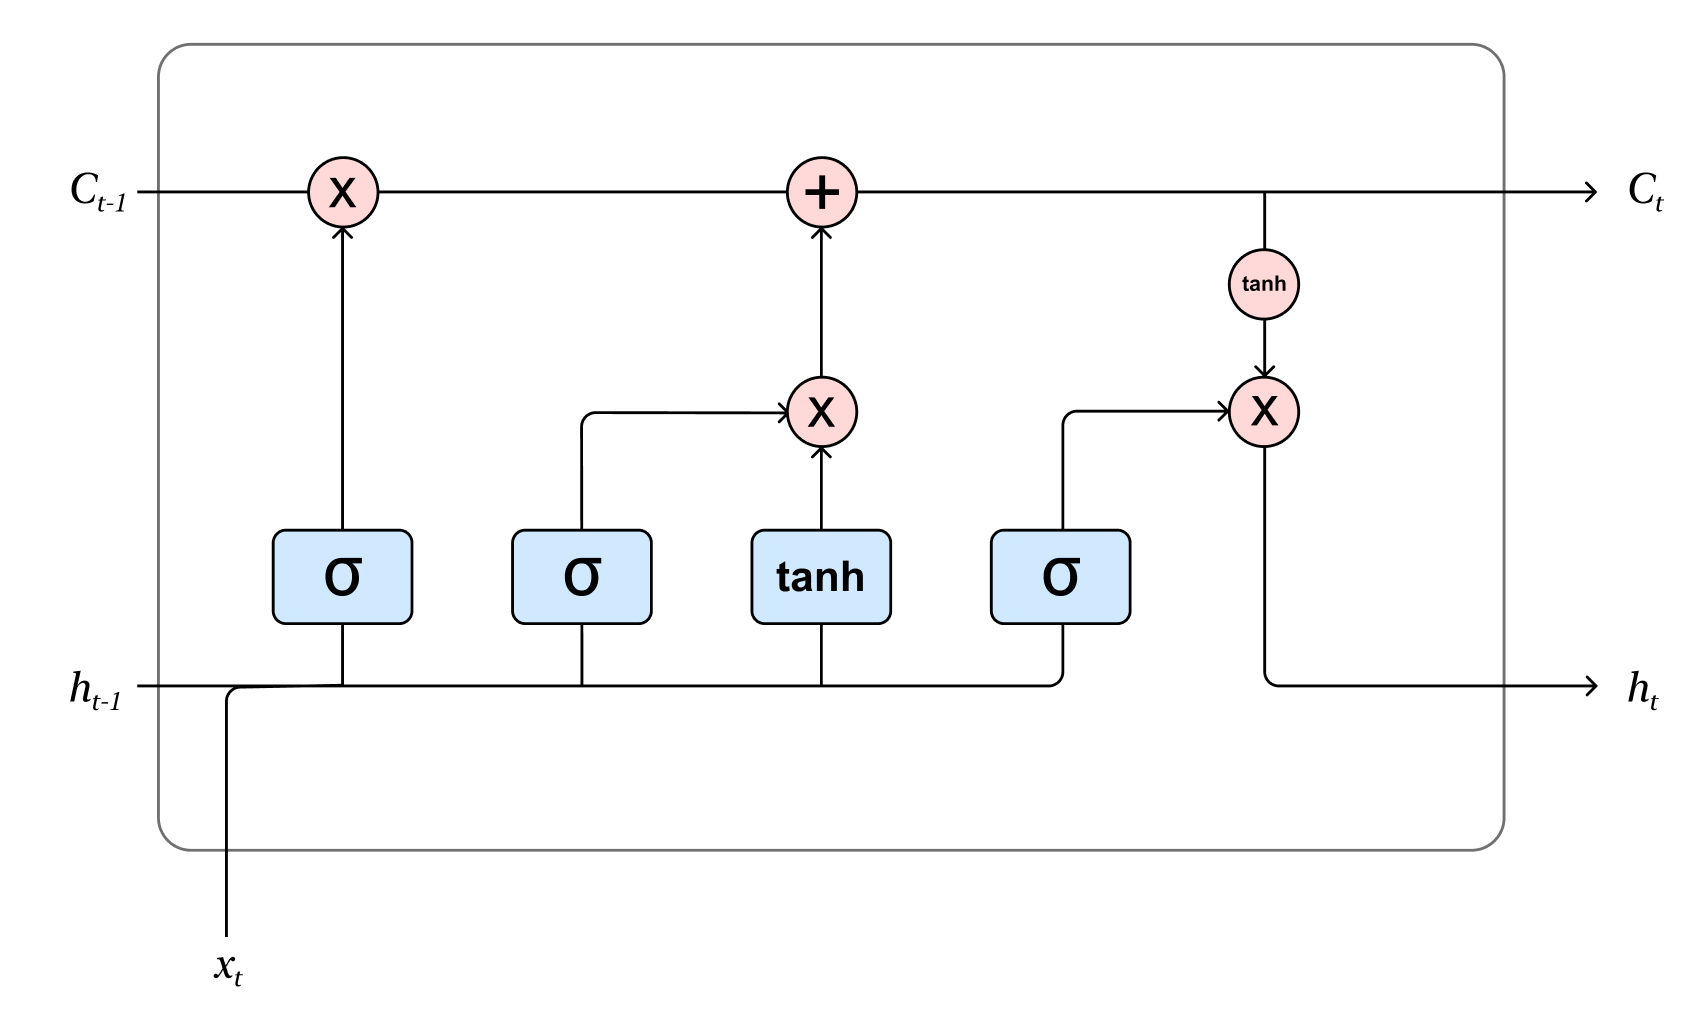

##### Class Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#import CustomLSTM as lstm

class LSTM(nn.Module):

    def __init__(self,input_dim: int, hidden_dim: int, num_layers: int):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.question_layers = nn.ModuleList()
        self.context_layers = nn.ModuleList()
  
        for i in range(self.num_layers):
            self.question_layers.append(CustomLSTM(input_dim, hidden_size))
            self.context_layers.append(CustomLSTM(input_dim, hidden_size))

        self.MI_LSTM_layer = milstm.MultiInputLSTM(hidden_size, hidden_size)
        self.Attention_layer = milstm.Attention(hidden_size, hidden_size)

        self.lin_layer = nn.Linear(hidden_size, 1)

    def forward(self, Q, C):
        Q_list = list()
        C_list = list()
        for i in range(self.seq_size):
            Q_out, Q_hidden = self.question_layers[i](Q[:,:,i:i+1])
            Q_list.append(Q_hidden)
            C_out, C_hidden = self.context_layers[i](C[:,:,i:i+1])
            C_list.append(C_hidden)
        Q_tensor = torch.stack(Q_list)
        Q_tilde = torch.mean(Q_tensor, 0)
        C_tensor = torch.stack(C_list)
        C_tilde = torch.mean(C_tensor, 0)
        Y_tilde_prime_out, Y_tilde_prime_hidden = self.MI_LSTM_layer(Q_tilde, C_tilde)

        y_tilde = self.Attention_layer(Y_tilde_prime_hidden)
        output = torch.relu(self.lin_layer(y_tilde))
        return output

##### Forward-function

In [ ]:
import torch
import torch.nn as nn
import math


class CustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_g = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_g = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_g = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        bs, seq_sz, _ = x.shape  # assumes x.shape represents (batch_size, sequence_size, input_size)
        hidden_seq = []
        carry_seq = []
        h_t = torch.zeros(bs, self.hidden_size)  # initialize states
        c_t = torch.zeros(bs, self.hidden_size)

        for t in range(seq_sz):
            x_t = x[:, t, :]

            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            g_t = torch.tanh(x_t @ self.U_g + h_t @ self.V_g + self.b_g)

            c_t = f_t * c_t + i_t * g_t

            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))  # transform h_t from shape (batch_size, input_size) to shape (1, batch_size, input_size)

        # reshape hidden_seq
        hidden_seq = torch.cat(hidden_seq,dim=0)  # concatenate list of tensors into one tensor along dimension 0 (sequence_size, batch_size, input_size)
        hidden_seq = hidden_seq.transpose(0,1).contiguous()  # exchange new dimension with batch dimension so that new tensor has required shape (batch_size, sequence_size, input_size)
        return h_t, hidden_seq

In [ ]:
import torch
import torch.nn as nn
import math


class MultiInputLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        # i_q_t
        self.W_i_q = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i_q = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i_q = nn.Parameter(torch.Tensor(hidden_sz))

        # i_c_t
        self.W_i_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i_c = nn.Parameter(torch.Tensor(hidden_sz))

        # f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        # c_q_t
        self.W_c_q = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c_q = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c_q = nn.Parameter(torch.Tensor(hidden_sz))

        # c_c_t
        self.W_c_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c_c = nn.Parameter(torch.Tensor(hidden_sz))

        # o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        # a_t
        self.W_a = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_a = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
        torch.nn.init.zeros_(self.W_c_q)
        torch.nn.init.zeros_(self.U_c_q)
        torch.nn.init.zeros_(self.b_c_q)
        torch.nn.init.zeros_(self.W_c_c)
        torch.nn.init.zeros_(self.U_c_c)
        torch.nn.init.zeros_(self.b_c_c)

    def forward(self, Q, C):
        bs, seq_sz, _ = Q.size()
        hidden_seq = []
        h_t, c_t = (
            torch.zeros(bs, self.hidden_size),
            torch.zeros(bs, self.hidden_size),
        )

        for t in range(seq_sz):
            Q_t = Q[:, t, :]
            C_t = C[:, t, :]

            i_q_t = torch.sigmoid(Q_t @ self.W_i_q + h_t @ self.U_i_q + self.b_i_q)
            i_c_t = torch.sigmoid(C_t @ self.W_i_c + h_t @ self.U_i_c + self.b_i_c)

            f_t = torch.sigmoid(Q_t @ self.W_f + h_t @ self.U_f + self.b_f)

            C_q_tilde_t = torch.tanh(Q_t @ self.W_c_q + h_t @ self.U_c_q + self.b_c_q)
            C_c_tilde_t = torch.tanh(C_t @ self.W_c_c + h_t @ self.U_c_c + self.b_c_c)

            o_t = torch.sigmoid(Q_t @ self.W_o + h_t @ self.U_o + self.b_o)

            l_q_t = C_q_tilde_t * i_q_t
            l_c_t = C_c_tilde_t * i_p_t

            u_q_t = torch.tanh(l_q_t @ self.W_a * c_t + self.b_a)
            u_c_t = torch.tanh(l_p_t @ self.W_a * c_t + self.b_a)

            alpha_t = torch.softmax(torch.stack([u_q_t, u_c_t]), dim=0)
            L_t = alpha_t[0, :, :] * l_q_t + alpha_t[1, :, :] * l_c_t

            c_t = f_t * c_t + L_t
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return h_t, hidden_seq

In [ ]:
class Attention(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        # i_t
        self.W_b = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.b_b = nn.Parameter(torch.Tensor(hidden_sz))
        self.v_b = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, Y_tilde_prime):

        j_t_list = list()
        for i in range(20):
            temp = Y_tilde_prime[:, i, :] @ self.W_b
            j_t_list.append(torch.tanh(temp + self.b_b) @ self.v_b.t())

        beta = torch.softmax(torch.stack(j_t_list), dim=0)
        y_tilde = Y_tilde_prime.permute(0,2,1) @ torch.unsqueeze(beta.transpose(0,1), dim=2)
        return y_tilde.squeeze()


##Reasoning-Modell

Das Reasoning-Modell verbindet nun die RNN Encoding-Layer und die LSTM Reasoning-Layer in eine übergreifende Architektur. Dabei kann es beliebig viele LSTM Reasoning-Layer geben. 

Zunächst müssen sowohl Fragen als auch der Kontext mittels des GloVe-Modells embedded werden. Anschließend fließen die Outputs der Embedding-Operationen in die erste RNN Encoding-Layer. Der daraus resultierende Output wird dann zunächst direkt in den Anfang des Reasoning-Abschnitts eingepflegt. Hierbei werden Fragen und Kontext noch separat von einander behandelt. Während des Durchlaufens des LSTMs wird jedoch eine Fragen-Kontext Interaktion durchgeführt.

Durch die Änderung des Datensatzes kann die originale Architektur nicht umgesetzt werden, sodass die Pooling-Layer der Fragen sowie die Fakten-Sequenz ausgelassen werden müssen. 

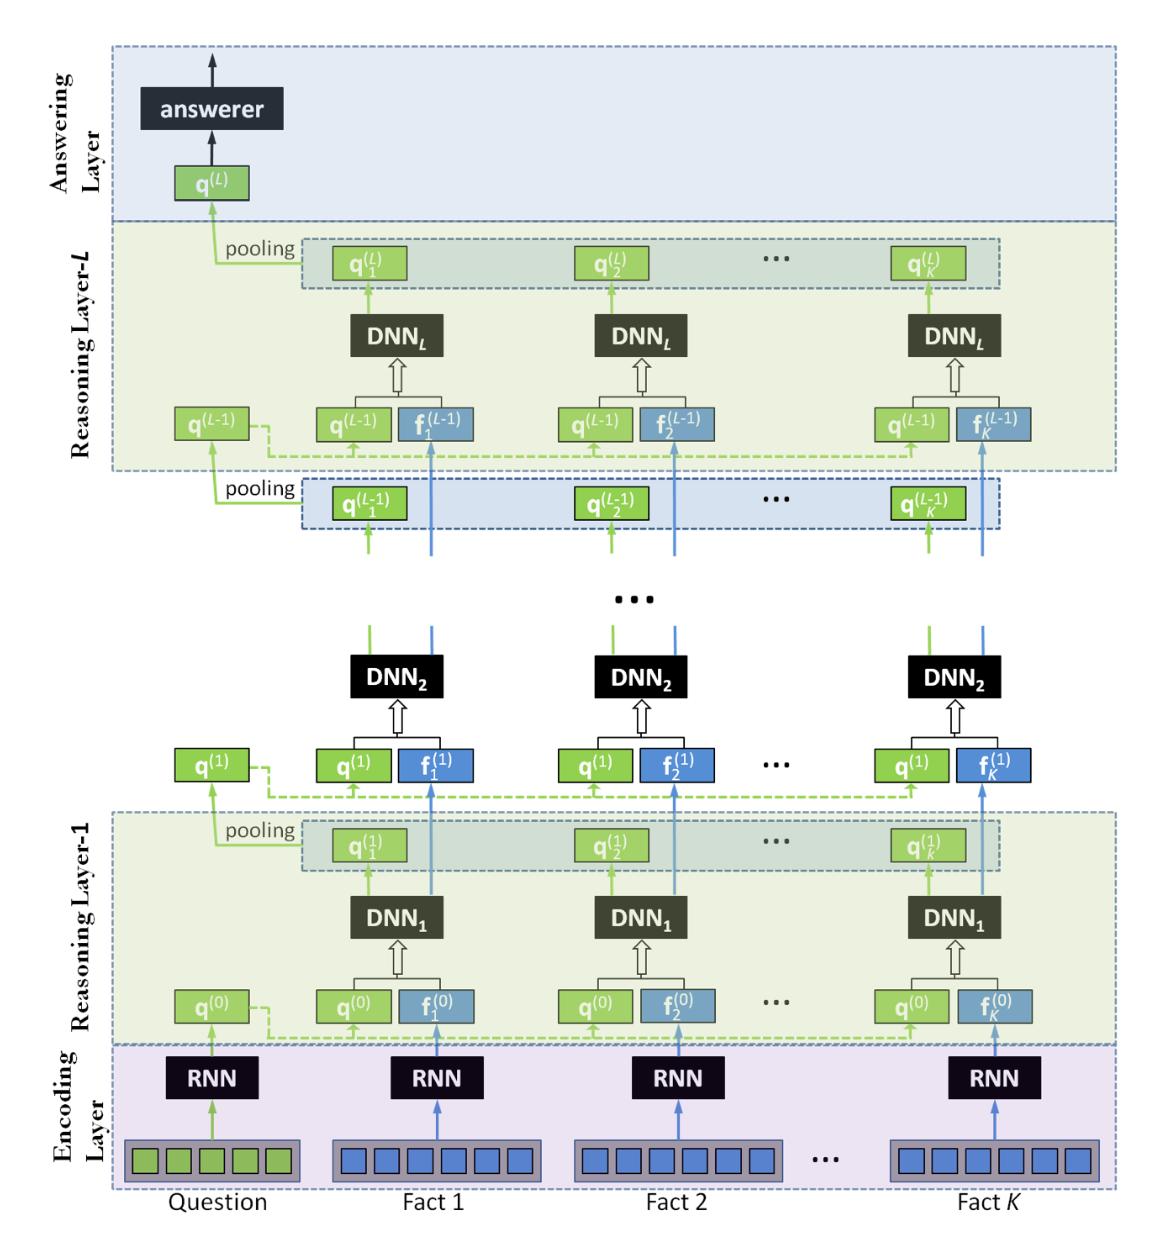

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#import custom_rnn as rnn

class Model(nn.Module):

    def __init__(self, hidden_dim: int, embedding_dim: int, num_layers: int, num_lstms: int):
        super(Model, self).__init__()
        self.glove_embedding = self.get_glove_embedding()
        self.rnn = RNN(embedding_dim, hidden_dim, num_layers)
        self.lstm = LSTM(embedding_dim, hidden_dim, num_layers)

    def get_glove_embedding(self):
        weights_matrix = np.load('drqaglove_vt.npy')
        num_embeddings, embedding_dim = weights_matrix.shape
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix),freeze=False)
        return embedding

    def forward(self, context, question):

        question_embedded = self.glove_embedding(question)
        context_embedded = self.glove_embedding(context)

        question_out, question_hidden = self.rnn(question_embedded)
        context_out, context_hidden = self.rnn(context_embedded)

        #question_out, question_hidden = self.lstm(question_hidden)
        #context_out, context_hidden = self.lstm(context_hidden)

        #context_hidden = torch.bmm(context_hidden, question_out)
        #question_out, question_hidden = self.lstm(question_hidden)
        #context_out, context_hidden = self.lstm(context_hidden)

        #context_hidden = torch.bmm(context_hidden, question_out)
        #question_out, question_hidden = self.lstm(question_hidden)
        #context_out, context_hidden = self.lstm(context_hidden)

        out = self.lstm(question_out, context_out)

        #out, hidden = self.layer_1(x) # returns tuple consisting of output and sequence
        #out, hidden = self.layer_2(hidden)
        output = torch.relu(self.layer_3(out))
        return output


##Parameters

In [ ]:
HIDDEN_DIM = 128
EMB_DIM = 300
NUM_LAYERS = 3
NUM_LSTMS = 5


model = Model(HIDDEN_DIM,
                       EMB_DIM, 
                       NUM_LAYERS,
                       NUM_LSTMS)

##Training

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
T = 20
batch_size = 512
q = 64

dataset = CustomDataset()
loader = DataLoader(dataset=dataset, batch_size=batch_size)

net = Model(T, q)

criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):

    running_loss = 0

    for Y, labels, X_p, X_n in loader:
        optimizer.zero_grad()
        outputs = net(Y.float(), X_p.float(), X_n.float())
        loss = criterion(torch.squeeze(outputs), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(loss.item())

    print('Epoch loss: ' + str(running_loss / len(loader)))
